### Business Problem
Company XYZ sells a software for \\$39. Since revenue has been flat for some time, the VP of Product has decided to run a test increasing the price. She hopes that this would increase revenue. In the experiment, 66\% of the users have seen the old price ($39), while a random sample of 33% users a higher price (\\$59).

The test has been running for some time and the VP of Product is interested in understanding how it went and whether it would make sense to increase the price for all the users.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from scipy.stats import ttest_ind
import statsmodels.stats.api as sms

In [2]:
test = pd.read_csv("C:\\Users\\Xiaochen\\Desktop\\Project\\Pricing_Test\\test_results.csv")
test.head()

,user_id,timestamp,source,device,operative_system,test,price,converted
0,604839,2015-05-08 03:38:34,ads_facebook,mobile,iOS,0,39,0
1,624057,2015-05-10 21:08:46,seo-google,mobile,android,0,39,0
2,317970,2015-04-04 15:01:23,ads-bing,mobile,android,0,39,0
3,685636,2015-05-07 07:26:01,direct_traffic,mobile,iOS,1,59,0
4,820854,2015-05-24 11:04:40,ads_facebook,web,mac,0,39,0


In [3]:
user = pd.read_csv("C:\\Users\\Xiaochen\\Desktop\\Project\\Pricing_Test\\user_table.csv")
user.head()

,user_id,city,country,lat,long
0,510335,Peabody,USA,42.53,-70.97
1,89568,Reno,USA,39.54,-119.82
2,434134,Rialto,USA,34.11,-117.39
3,289769,Carson City,USA,39.15,-119.74
4,939586,Chicago,USA,41.84,-87.68


In [4]:
# check missing values
print(test.isnull().sum())

user_id             0
timestamp           0
source              0
device              0
operative_system    0
test                0
price               0
converted           0
dtype: int64


In [5]:
print(user.isnull().sum())

user_id    0
city       0
country    0
lat        0
long       0
dtype: int64


In [6]:
# Join the two datasets
data = pd.merge(left = test, right = user, how = 'left', on = 'user_id')
data.head()

,user_id,timestamp,source,device,operative_system,test,price,converted,city,country,lat,long
0,604839,2015-05-08 03:38:34,ads_facebook,mobile,iOS,0,39,0,Buffalo,USA,42.89,-78.86
1,624057,2015-05-10 21:08:46,seo-google,mobile,android,0,39,0,Lakeville,USA,44.68,-93.24
2,317970,2015-04-04 15:01:23,ads-bing,mobile,android,0,39,0,Parma,USA,41.38,-81.73
3,685636,2015-05-07 07:26:01,direct_traffic,mobile,iOS,1,59,0,Fayetteville,USA,35.07,-78.90
4,820854,2015-05-24 11:04:40,ads_facebook,web,mac,0,39,0,Fishers,USA,39.95,-86.02


In [7]:
# check missing values again
print(data.isnull().sum())

user_id                 0
timestamp               0
source                  0
device                  0
operative_system        0
test                    0
price                   0
converted               0
city                41184
country             41184
lat                 41184
long                41184
dtype: int64


In [8]:
# some users are only in the test table but not in the user table
# let's check if those missing values are exactly the number of rows in the test table - user table
print(max(data.isnull().sum())==(test.shape[0]-user.shape[0]))

True


In [9]:
# Now I want to check if people in the test group always get $59 and people in control group get $39
data[['user_id','test','price']].groupby(['test','price']).count()

user_id
test price         
0    39      202517
     59         210
1    39         155
     59      113918

In [10]:
# remove the wrong data
data=data[((data['test']==0) & (data['price']==39)) | ((data['test']==1) & (data['price']==59))]

In [11]:
data[['user_id','test','price']].groupby(['test','price']).count()

,,user_id
test,price,
0,39,202517
1,59,113918


In [12]:
# create a new variable called revenue
data['revenue'] = data['converted'] * data['price']

In [13]:
data['revenue'].describe()

count    316435.000000
mean          0.827083
std           6.179009
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          59.000000
Name: revenue, dtype: float64

### Price Optimization

In [14]:
# compare the conversion rate between test and control
data[['converted', 'test']].groupby('test').mean()

,converted
test,
0,0.019900
1,0.015555


In [15]:
# t-test
print(ttest_ind(data[data['test']==1]['revenue'], data[data['test']==0]['revenue'], equal_var=False))

Ttest_indResult(statistic=5.715224666463108, pvalue=1.0972577312420781e-08)


revenue per user is up and highly statistically significant

Check how different segments are reacting to the test which could give us useful information about user price sensitivity by segment

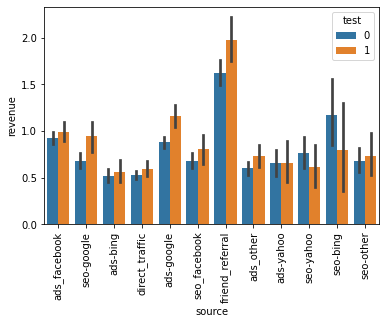

In [21]:
# revenue by source
sns.barplot(x='source', y='revenue', hue='test', data=data)
plt.xticks(rotation=90)
plt.show()

- Most segments agree with the overall finding of an increase in revenue as we increase price
- There are three segments with that control group wins: ads-yahoo, seo-yahoo, and seo-bing
- The three segments with the higher avg revenue with the new price happen to be the most expensive ones, i.e. friend referral, and google/FB ads

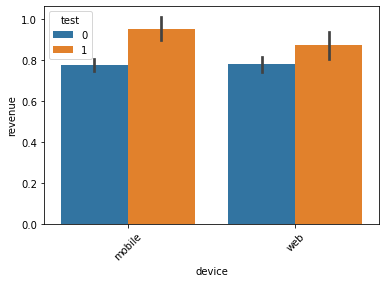

In [22]:
# revenue by device
sns.barplot(x='device', y='revenue', hue='test', data=data)
plt.xticks(rotation=45)
plt.show()

It appears that mobile users are less price sensitive. This is typically very good as mobile is in most cases the channel that’s proportionally growing more between the two. So, in the long run, the revenue gain from the price change could be even larger.

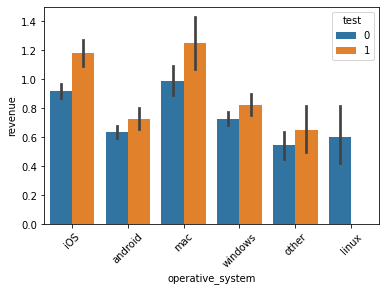

In [23]:
# revenue by operative system
sns.barplot(x='operative_system', y='revenue', hue='test', data=data)
plt.xticks(rotation=45)
plt.show()

Not surprisingly, we can see that mac/iOS react better to the price increase. Most likely, they are acting as a proxy for different user characteristics. It would probably be a good idea to figure out how to get more of those users and target them more via, for instance, ads or ad-hoc marketing campaigns.

Linux has 0% conversion rate for the test group. It's most likely a bug and we need to remove the segment from the dataset. 

In [24]:
# check % of linux users
data.query('operative_system==\'linux\'').shape[0]/data.shape[0]*100

1.305165357814401

In [25]:
#Check avg revenue per user after removing Linux
data = data.query('operative_system!=\'linux\'')
print(data[['revenue','test']].groupby('test').mean())

       revenue
test          
0     0.778002
1     0.933531


In [26]:
# re-run t-test
ttest_ind(data.query('test==1')['revenue'], data.query('test==0')['revenue'], equal_var=False)

Ttest_indResult(statistic=6.184240028400434, pvalue=6.253458285742887e-10)

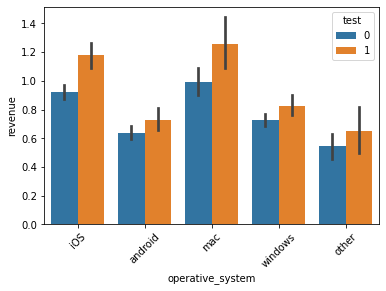

In [27]:
# re-run revenue by operative system
sns.barplot(x='operative_system', y='revenue', hue='test', data=data)
plt.xticks(rotation=45)
plt.show()

In [28]:
# revenue by city

#first, select the top 10 cities with the most users
top_cities=data['city'].value_counts().reset_index().sort_values('city', ascending=False).head(10)
print(top_cities)

          index   city
0      New York  25401
1       Chicago   7071
2       Houston   6608
3   San Antonio   4554
4   Los Angeles   4089
5      San Jose   3312
6  Indianapolis   3177
7  Jacksonville   2865
8  Philadelphia   2488
9     Las Vegas   2375


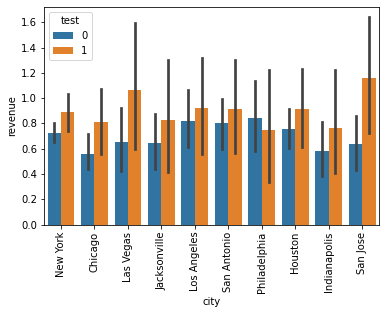

In [29]:
#plot avg revenue for top 10 cities
sns.barplot(x='city', y='revenue', hue='test', data=data[data['city'].isin(top_cities['index'])])
plt.xticks(rotation=90)
plt.show()

### Length of the A/B Test

In [31]:
conversion_rate_control = test.query('test==0').converted.mean()
p1_and_p2 = sms.proportion_effectsize(conversion_rate_control, conversion_rate_control*39/59)
sample_size = round(sms.NormalIndPower().solve_power(p1_and_p2, power=0.8, alpha=0.05))
print("The required sample size per group is ~", sample_size)

The required sample size per group is ~ 5548


In [32]:
# weekly users
#create a column that's week of the year
test['week_year'] = pd.to_datetime(test.timestamp.str.split(' ').str[0]).dt.strftime('%W')
#take avg count of users per week. We remove first and last week, just in case they don't include all 7 days
users_week = test['week_year'].value_counts().sort_index()
users_week = users_week.drop(users_week.index[[0,(users_week.shape[0]-1)]]).mean()
  
print("Avg number of users per week is:", round(users_week))

Avg number of users per week is: 24356


In [35]:
print("The percentage of traffic that needs to be in test is", round(sample_size/(users_week*2)*100))

The percentage of traffic that needs to be in test is 11


In [39]:
print("if we run the test on 50% of the users, we could get it done in ", round(sample_size * 2 / users_week, 2), " week(s)")

if we run the test on 50% of the users, we could get it done in  0.46  week(s)


If we ran the test on 50% of the users, we would be done in less than a week. However, it is a good practice to run the test for at least two weeks regardless of that, so that we can get weekly patterns.

### Business Insights

- Friend-referral is by far the best channel. Any UI/UX change that emphasizes it even more is likely to lead to revenue gains
- After referrals, FB/Google ads have higher revenue per user than any other channel. This is kind of expected. However, SEO is not really that much behind. And SEO is free. Focusing on SEO and increasing its relative share of traffic would lead to much larger profits
- Mobile has larger revenue per user than web. This is an excellent news. Mobile share of traffic has been growing constantly over the last few years. Just by taking advantage of this trend, the company will make more money. If they could increase mobile traffic even more, they would make even more money. Bidding higher for mobile ads is probably a good idea
- iOS is doing much better than Android. Most likely, this is just because iOS users are less price sensitive than Android users. However, it would still be interesting investigating whether the actual product (i.e. UI/UX) is different between the two platforms
- Revenue per user varies greatly across segments. This could lead to potentially understanding why and coming up with different products, some cheaper and some more expensive